<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;"></td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;"></td>
            </tr>
            <tr>
                <td style="padding: 8px;"></td>
                <td style="padding: 8px;"></td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [53]:
#pip install gsgp_slim

In [54]:
# pip install slim_gsgp

In [55]:
#pip install -r requirements.txt

In [56]:
# Imports
import numpy as np
import pandas as pd

import os
import pickle
import datetime
import torch
import random

#import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
import gc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import wilcoxon, friedmanchisquare
#import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [57]:
from slim.main_gp import gp  # import the slim library
from slim.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim.utils.utils import train_test_split  # import the train-test split function

In [58]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [59]:
train_color = 'blue'
test_color = 'orange'

In [60]:
#! ls

#### Helpfull Functions

In [61]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [62]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

In [63]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [64]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [66]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [67]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [68]:
df.set_index('wing_tag', inplace = True)

In [69]:
df.duplicated().sum()

0

#### Data Types

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [71]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [72]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [73]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [74]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

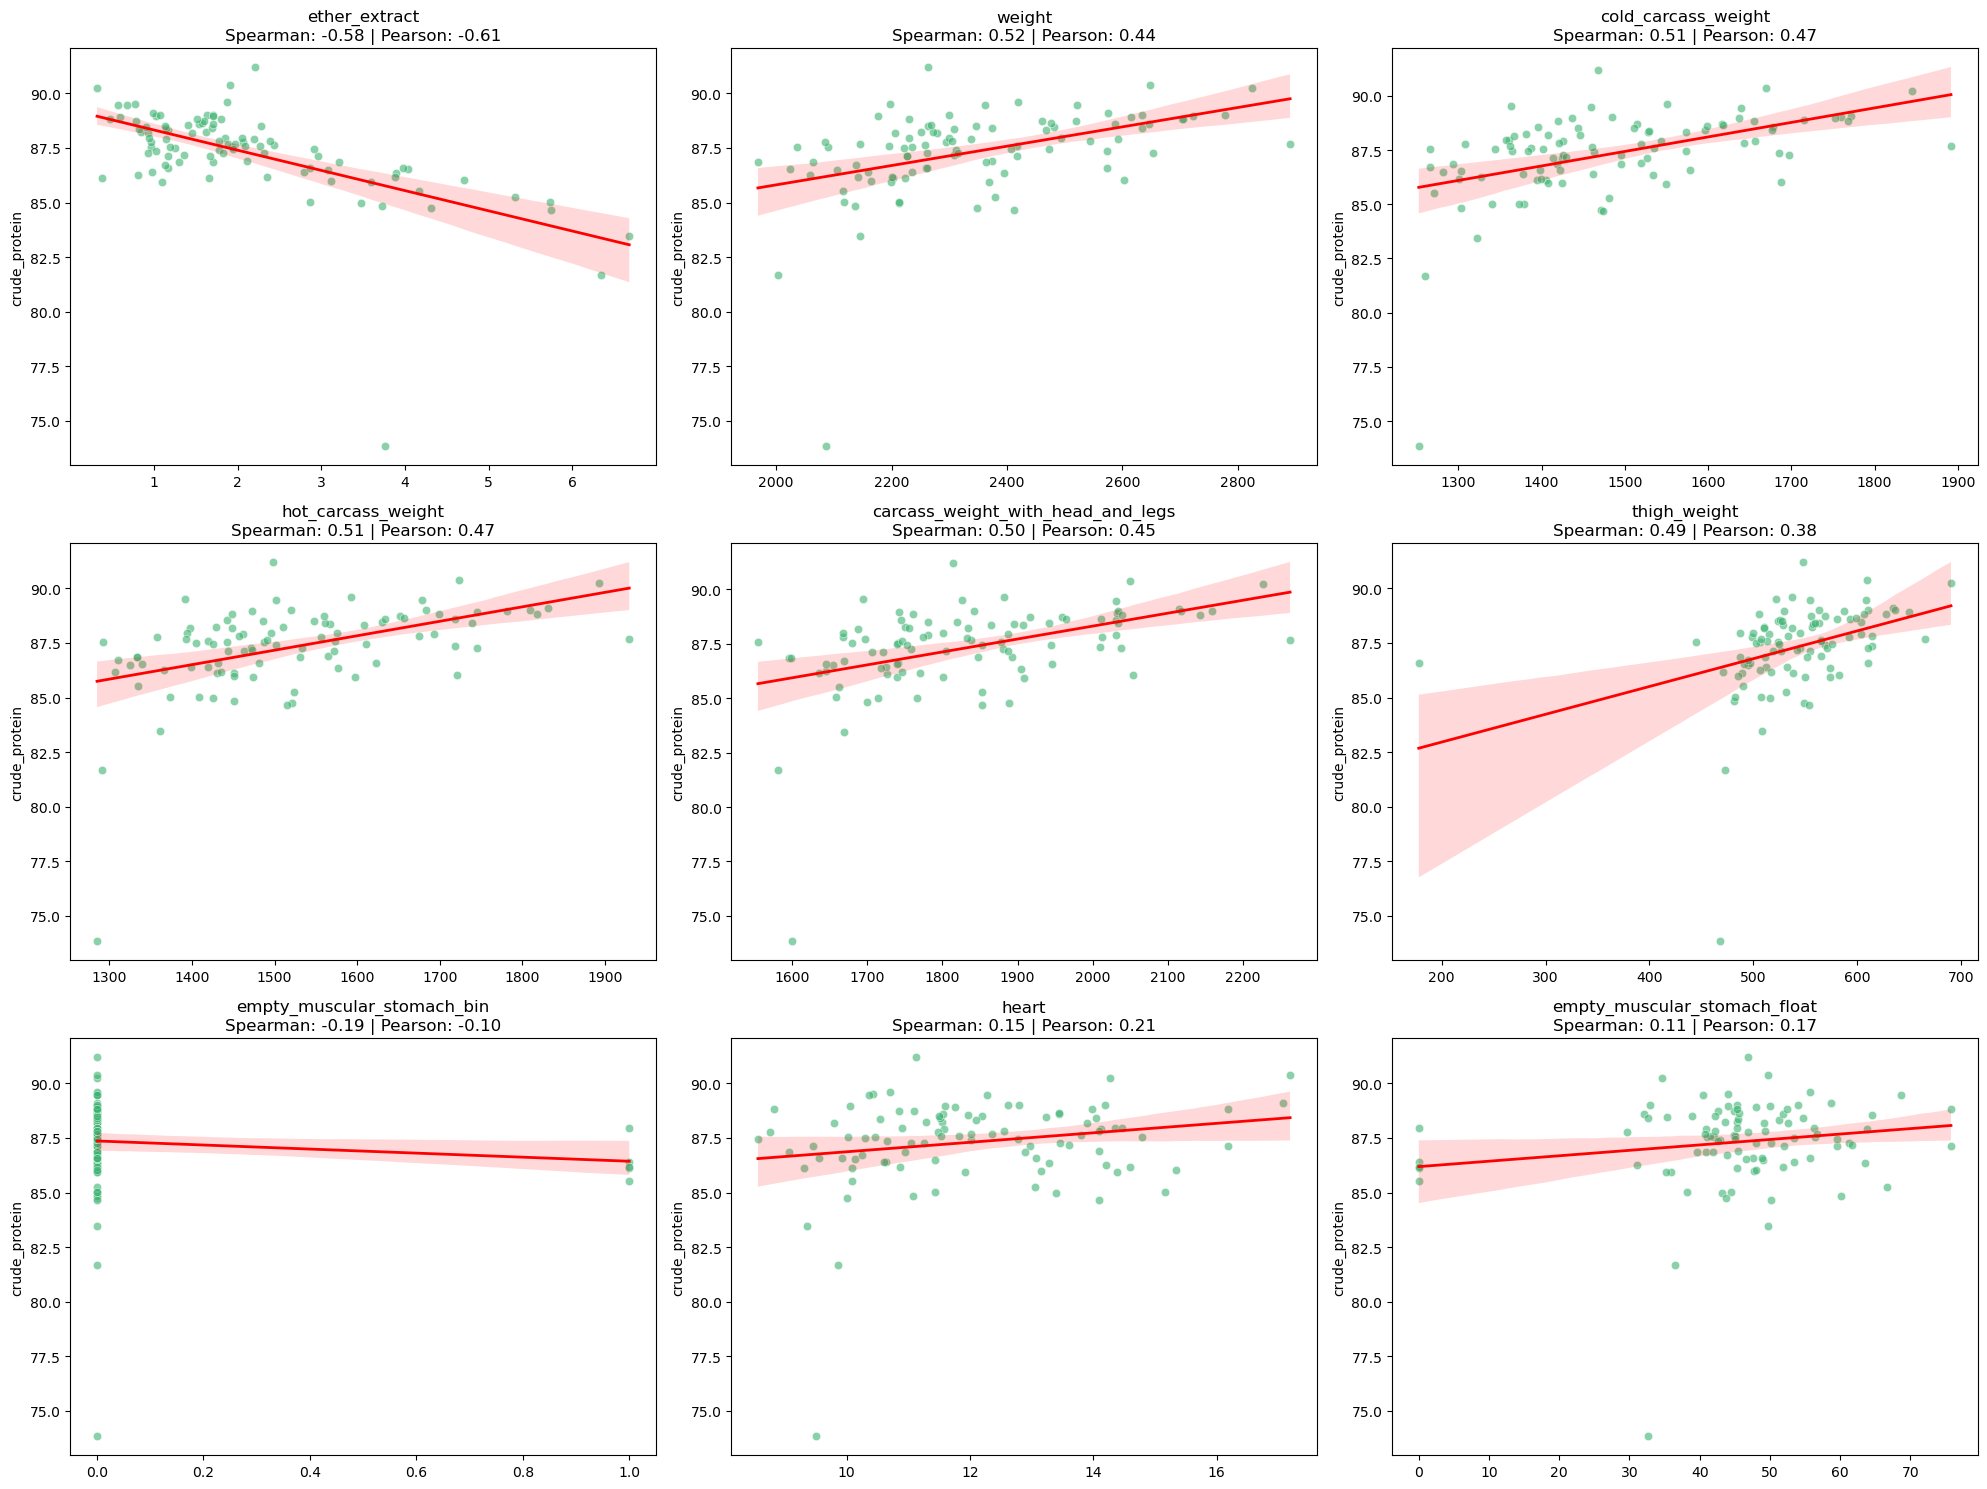

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [75]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

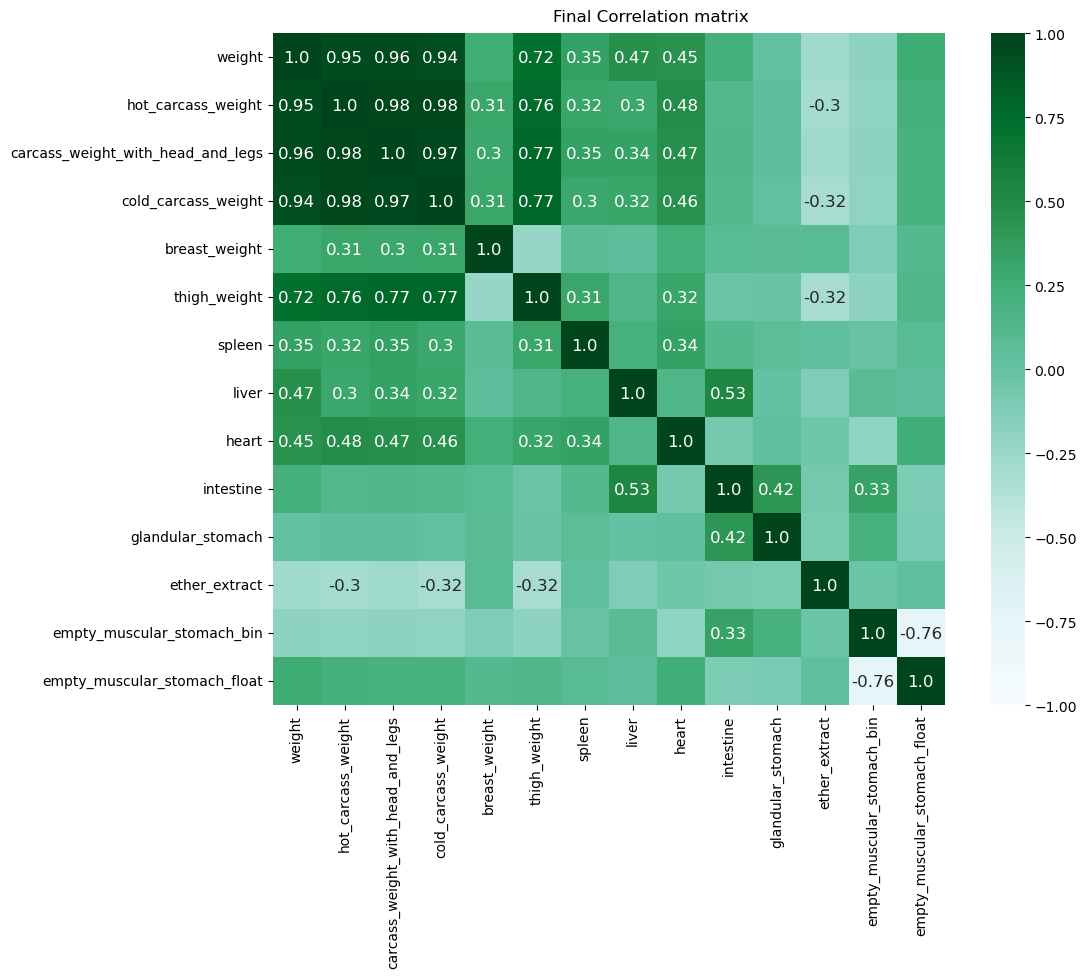

In [76]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

In [77]:
temos muitas corr, é para dar drop ou temos de usar todas 

SyntaxError: invalid syntax (3105232982.py, line 1)

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [78]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [79]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim)
- [5. Neural Network (NN)](#nn)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [470]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [475]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [ ]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

##### test

In [447]:
cv = KFold(n_splits=10, random_state=seed, shuffle=True)
data_cv = [[train_ix, test_ix] for train_ix, test_ix in cv.split(X, y)][0]

In [448]:
from sklearn.model_selection import KFold
import torch

# Create CV splits
cv = KFold(n_splits=10, random_state=seed, shuffle=True)
data_cv = [[train_ix, test_ix] for train_ix, test_ix in cv.split(X, y)][0]

X_train_tensor = torch.tensor(X.iloc[data_cv[0]].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y.iloc[data_cv[0]].values, dtype=torch.float32)
X_val_tensor   = torch.tensor(X.iloc[data_cv[1]].values, dtype=torch.float32)
y_val_tensor   = torch.tensor(y.iloc[data_cv[1]].values, dtype=torch.float32)

In [449]:
[X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape]

[torch.Size([86, 13]),
 torch.Size([86]),
 torch.Size([10, 13]),
 torch.Size([10])]

In [ ]:
gp_config = {
        'initializer': '',
        'sspace': {
            'p_constants': 0.5,
            'max_init_depth': 3,
            'max_depth': 10,
            'tree_constants': ,
        },
        'pop_size': 50,
        'xo_prob': 0.9,
        'generations': 30,
    }

In [462]:
SEED = 63

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATASET_NAME = 'Chicken'
FITNESS_FUNCTION = 'rmse'
MINIMIZATION = True
INITIALIZER = 'rhh'
TREE_CONSTANTS = [-0.1022770059668725, -0.9896814317724276, -0.6107837209894387, -0.8363821971401804, 0.14363923382271682, -0.9492561222573423, 0.47488835790199024, 0.9561912222139382, -0.15235948625541207, -1.0]
TREE_FUNCTIONS = ['add', 'subtract', 'multiply', 'divide']
PROB_CONSTANT = 0.5
MAX_INIT_DEPTH = 3
MAX_DEPTH = 10 #fez muita diferença
POP_SIZE = 50
P_XO = 0.9
ELISTISM = True
N_ELITES = 1
TOURNAMENT_SIZE = 2
GENERATIONS = 30
VERBOSE = 1
LOG_LEVEL = 2
LOG_DIR = './log/PC2/'
LOG_PATH = LOG_DIR+'gp_'+DATASET_NAME+'.csv'

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)

print(f'Total evaluations: {POP_SIZE*GENERATIONS}\n')

Total evaluations: 1500



In [463]:
model = gp(
    # ---
    # Search Space
    init_depth=MAX_INIT_DEPTH,
    max_depth=MAX_DEPTH,
    tree_constants=TREE_CONSTANTS,
    tree_functions=TREE_FUNCTIONS,
    prob_const = PROB_CONSTANT,
    # --
    # Problem Instance
    X_train=X_train_tensor, y_train=y_train_tensor, 
    X_test=X_val_tensor, y_test=y_val_tensor,
    dataset_name=DATASET_NAME,
    fitness_function=FITNESS_FUNCTION,
    minimization=MINIMIZATION,
    # --
    # GP instance 
    pop_size=POP_SIZE,
    p_xo = P_XO,
    initializer=INITIALIZER,
    tournament_size = TOURNAMENT_SIZE,
    # ---
    # Solve settings
    n_iter=GENERATIONS,
    elitism=ELISTISM,
    n_elites=N_ELITES,
    test_elite=True,
    log_path=LOG_PATH,
    log_level=LOG_LEVEL,
    verbose=VERBOSE,
    n_jobs=1,
    seed=SEED
)


Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Chicken             |       0      |   19.66050148010254   |   17.51974105834961      |   0.008621454238891602 |      3           |
|     Chicken             |       1      |   19.66050148010254   |   17.51974105834961      |   0.009130477905273438 |      3           |
|     Chicken             |       2      |   13.680819511413574  |   9.378312110900879      |   0.008458614349365234 |      3           |
|     Chicken             |       3      |   13.619598388671875  |   12.831721305847168     |   0.013484716415405273 |      3           |
|     Chicken    

In [464]:
pd.read_csv(LOG_PATH, header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,StandardGP,79dea657-32b8-11f0-9c7d-cc5ef8d750ac,Chicken,63,0,19.660501,0.008621,200.0,17.519741,3,0.0,1.085628e+08,2
1,StandardGP,79dea657-32b8-11f0-9c7d-cc5ef8d750ac,Chicken,63,1,19.660501,0.009130,206.0,17.519741,3,0.0,7.318858e+04,2
2,StandardGP,79dea657-32b8-11f0-9c7d-cc5ef8d750ac,Chicken,63,2,13.680820,0.008459,182.0,9.378312,3,0.0,1.758333e+03,2
3,StandardGP,79dea657-32b8-11f0-9c7d-cc5ef8d750ac,Chicken,63,3,13.619598,0.013485,182.0,12.831721,3,0.0,2.421152e+02,2
4,StandardGP,79dea657-32b8-11f0-9c7d-cc5ef8d750ac,Chicken,63,4,13.619598,0.012385,206.0,12.831721,3,0.0,1.234276e+03,2


In [465]:

fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Train vs Test Fitness ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()


In [466]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('GP - Fitness evolution ('+DATASET_NAME+' dataset)', 'GP - Size evolution ('+DATASET_NAME+' dataset)')
)

fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,9].values, 
                         mode='lines', name='Size'), row=1, col=2)
fig.update_layout(
    width=1000,
    height=400, 
    showlegend=True,
    yaxis_range=[0,None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)
fig.show()

In [467]:
model.print_tree_representation()
# model.node_count

add(
  x9
  add(
    constant_0.9561912222139382
    add(
      constant_0.47488835790199024
      add(
        constant_0.9561912222139382
        add(
          constant_0.47488835790199024
          add(
            constant_0.9561912222139382
            add(
              constant_0.9561912222139382
              add(
                constant_0.9561912222139382
                x8
              )
            )
          )
        )
      )
    )
  )
)


In [468]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,11].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Population Fitness Diversity ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='Fitness Standard Deviation'
)
fig.show()

In [469]:
[model.fitness, model.test_fitness]

[tensor(12.2639), tensor(6.9003)]

#### end test

In [431]:
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

In [486]:
from sklearn.metrics import mean_squared_error

In [487]:
# ===================== GP CV Wrapper =====================
def cross_val_gp_slim(X, y, k_outer=10, k_inner=5, verbose_reporter=False, save_logs=False, **gp_config):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    scores = []
    dataset_name = "Chicken"

    log_dir = "./log/GP/"
    os.makedirs(log_dir, exist_ok=True)
        
    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=k_outer, k_inner=k_inner, random_state=gp_config['seed'])):
        best_inner_score = float('inf')
        best_model = None
        best_scaler_y = None

        # ============ Inner Loop ============
        for inner_train_idx, inner_val_idx in fold_data['inner_splits']:
            X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
            y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
            X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
            y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

            # Scaling
            x_scaler = RobustScaler()
            y_scaler = RobustScaler()
            X_train_scaled = x_scaler.fit_transform(X_train)
            X_val_scaled = x_scaler.transform(X_val)

            y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
            y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

            # Tensors
            X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

            # GP model
            model = gp(
                X_train=X_train_tensor, y_train=y_train_tensor,
                X_test=X_val_tensor, y_test=y_val_tensor,
                dataset_name=dataset_name,
                fitness_function='rmse',
                minimization=True,
                
                # --- Search space ---
                initializer=gp_config['initializer'],
                tree_constants=gp_config['sspace']['tree_constants'],
                tree_functions=['add', 'subtract', 'multiply', 'divide'],
                prob_const=gp_config['sspace']['p_constants'],
                init_depth=gp_config['sspace']['max_init_depth'],
                max_depth=gp_config['sspace']['max_depth'],
                
                # --- GP parameters ---
                pop_size=gp_config['pop_size'],
                p_xo=gp_config['xo_prob'],
                elitism=True,
                n_elites=1,
                tournament_size=2,
                
                # --- Solve settings ---
                n_iter=gp_config['generations'],
                test_elite=True,
                log_level=2 if save_logs else 0,
                log_path=f"{log_dir}/gp_{dataset_name}_fold{fold_idx+1}.csv" if save_logs else None,
                verbose=1 if verbose_reporter else 0,
                n_jobs=1,
                seed=gp_config['seed']
            )

            # Evaluate validation RMSE
            with torch.no_grad():
                y_pred = model.predict(X_val_tensor).numpy().reshape(-1, 1)
                y_true = y_val_tensor.numpy().reshape(-1, 1)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                if rmse < best_inner_score:
                    best_inner_score = rmse
                    best_model = model
                    best_scaler_y = y_scaler
                    best_scaler_x = x_scaler

        # ============ Outer Test Evaluation ============
        X_outer_train = fold_data['X_outer_train']
        X_test = fold_data['X_test']
        y_test = fold_data['y_test']

        # The model was trained on one of the inner train splits of X_outer_train, 
        # so we need to use the scaler from that same inner train split

        X_test_scaled = best_scaler_x.transform(X_test)

        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

        with torch.no_grad():
            y_pred_scaled = best_model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(best_scaler_y, y_pred_scaled)
            print(y_pred_rescaled)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))

        print(f"[Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        scores.append(test_rmse)

    return np.array(scores)



| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[8, 10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[[random.uniform(-1, 1) for _ in range(9)] + [-1.] for _ in range(2)]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.2]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [ ]:
# ===================== Config Grid Setup =====================
TREE_CONSTANTS_SET = [[random.uniform(-1, 1) for _ in range(9)] + [-1.] for _ in range(2)]

param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.2, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.max_depth': [8, 10],
    'sspace.tree_constants': TREE_CONSTANTS_SET,
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [30, 50],
}

keys, values = zip(*param_grid.items())
param_combos = [dict(zip(keys, v)) for v in product(*values)]
seeds = [42, 25, 63]

# ===================== Grid Search Execution =====================
all_results = []

for config_id, flat_config in enumerate(param_combos):
    print(f"\n=== Testing Config {config_id+1}/{len(param_combos)} ===")

    gp_config = {
        'initializer': flat_config['initializer'],
        'sspace': {
            'p_constants': flat_config['sspace.p_constants'],
            'max_init_depth': flat_config['sspace.max_init_depth'],
            'max_depth': flat_config['sspace.max_depth'],
            'tree_constants': flat_config['sspace.tree_constants'],
        },
        'pop_size': flat_config['pop_size'],
        'xo_prob': flat_config['xo_prob'],
        'generations': flat_config['generations'],
    }

    config_scores = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        gp_config['seed'] = seed

        run_scores = cross_val_gp_slim(
            X=X,
            y=y,
            k_outer=5, k_inner=3,  
            verbose_reporter=False,
            save_logs=False,
            **gp_config
        )

        config_scores.extend(run_scores)
        print(f"→ RMSEs: {np.round(run_scores, 4)} | Mean: {np.mean(run_scores):.4f} ± {np.std(run_scores):.4f}")
        del run_scores; gc.collect()

    mean_score = np.mean(config_scores)
    all_results.append((gp_config, mean_score))
    print(f"\n✅ Config {config_id+1} avg RMSE = {mean_score:.4f}")

# ===================== Report Best Config =====================
sorted_results = sorted(all_results, key=lambda x: x[1])
best_config, best_score = sorted_results[0]

print("\n🏆 Best Config:")
print(best_config)
print(f"🏁 Best Mean RMSE: {best_score:.4f}")


=== Testing Config 1/32 ===
[88.45555  82.46806  86.598785 86.09875  83.58106  86.31733  85.58092
 82.5049   86.04613  86.98978  86.719864 87.63275  87.932106 86.182686
 89.402084 89.12184  88.63925  88.9856   87.947105 87.16105 ]
[Fold 1] Test RMSE: 1.2765
[87.15835  88.01778  88.56283  85.31551  86.23305  88.202515 87.63349
 85.37261  84.35083  88.868645 87.58649  83.1676   88.80717  86.56187
 87.3874   88.043945 88.62073  88.32077  87.50511 ]
[Fold 2] Test RMSE: 1.0578
[87.91868  86.562614 88.079346 88.00865  86.646164 87.16031  86.62045
 85.94564  87.75158  87.26957  87.719444 87.30813  86.20914  85.59859
 87.41096  87.42381  86.06775  88.31714  87.93796 ]
[Fold 3] Test RMSE: 2.9742
[88.17128  86.65831  84.94282  88.21893  88.421455 88.45719  87.36118
 88.349976 87.73049  88.647804 87.57562  87.44458  87.61136  86.15796
 87.21822  89.1839   86.71787  87.2897   87.76623 ]
[Fold 4] Test RMSE: 1.1993
[87.71336  88.44238  87.65976  88.3995   84.87235  88.49599  87.75625
 83.33928  88.

KeyboardInterrupt: 

In [ ]:
gp_config = {
        'initializer': 'rhh',
        'sspace': {
            'p_constants': 0.5,
            'max_init_depth': 3,
            'max_depth': 10,
            'tree_constants': [-0.1022770059668725, -0.9896814317724276, -0.6107837209894387, -0.8363821971401804, 0.14363923382271682, -0.9492561222573423, 0.47488835790199024, 0.9561912222139382, -0.15235948625541207, -1.0],
        },
        'pop_size': 50,
        'xo_prob': 0.9,
        'generations': 30,
    }
seed = 63
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
gp_config['seed'] = seed

for fold_data in enumerate(nested_cv_generator(X, y, k_outer=10, k_inner=5, random_state=seed)):
            X_train = fold_data['X_outer_train']
            y_train = fold_data['y_outer_train']
            X_test = fold_data['X_test']
            y_test = fold_data['y_test']

final_gp = cross_val_gp_slim(X=X,y=y,
                             k_outer=10, k_inner=5, verbose_reporter=True,
                             save_logs=True,**gp_config)

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Chicken             |       0      |   1.1232407093048096  |   0.8269090056419373     |   0.013279914855957031 |      7           |
|     Chicken             |       1      |   1.0772950649261475  |   0.9539927840232849     |   0.0118255615234375   |      3           |
|     Chicken             |       2      |   1.0772950649261475  |   0.9539927840232849     |   0.008731365203857422 |      3           |
|     Chicken             |       3      |   1.0541609525680542  |   0.5435528755187988     |   0.007483005523681641 |      3           |
|     Chicken    

In [443]:
LOG_PATH = './log\GP\gp_Chicken_fold8.csv'
pd.read_csv(LOG_PATH, header=None).head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,StandardGP,ea551216-32b0-11f0-a4ba-cc5ef8d750ac,Chicken,63,0,0.681119,0.007228,200.0,1.747513,3,0.0,7.993659,2
1,StandardGP,ea551216-32b0-11f0-a4ba-cc5ef8d750ac,Chicken,63,1,0.681119,0.005035,224.0,1.747513,3,0.0,2.450652,2
2,StandardGP,ea551216-32b0-11f0-a4ba-cc5ef8d750ac,Chicken,63,2,0.630761,0.004291,224.0,1.661617,5,0.0,4.436364,2
3,StandardGP,ea551216-32b0-11f0-a4ba-cc5ef8d750ac,Chicken,63,3,0.630761,0.005275,236.0,1.661617,5,0.0,0.602831,2
4,StandardGP,ea551216-32b0-11f0-a4ba-cc5ef8d750ac,Chicken,63,4,0.630761,0.004400,242.0,1.661617,5,0.0,0.340818,2


In [444]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Train vs Test Fitness ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()

In [439]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('GP - Fitness evolution ('+DATASET_NAME+' dataset)', 'GP - Size evolution ('+DATASET_NAME+' dataset)')
)

fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,9].values, 
                         mode='lines', name='Size'), row=1, col=2)
fig.update_layout(
    width=1000,
    height=400, 
    showlegend=True,
    yaxis_range=[0,None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)
fig.show()

In [440]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,11].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Population Fitness Diversity ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='Fitness Standard Deviation'
)
fig.show()

#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

usar isto para justificar o uso de rmse:


MAE is not very sensitive to outliers in comparison to MSE since it doesn’t
punish huge errors.


• MSE is more accurate than MAE as it highlights large errors over small ones.

• MSE is differentiable which helps find the minimum and maximum values
using mathematical methods more effectively.
But…

• MSE “squares” all the values, and so errors are extremized (each error point
has a large impact).

When to use MAE:
• when outliers in the data are comparatively
low, as it is not very sensitive to the outlier

It is used when the performance is measured
on continuous variable data as it gives a linear
value, which averages the weighted individual
differences equally.
When to use MSE:
• when the dataset contains outliers, or
unexpected values (too high or too low
values).


When to use RMSE:
• RMSE assigns a higher weight to larger
errors as errors are squared before they are
averaged.
This indicates that RMSE is much more useful
when large errors are present and they
drastically affect the model’s performance.





<a id="final-testing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Testing the final model</h3>
</div>

[Back to Index](#idx)